<img src="https://i.imgur.com/P8nEfa5.png" width="200" height="150">
<br>
<div align="center">
    <h1><u> LARINGE ELETRÔNICA - LIGA DE DATA SCIENCE </u></h1>
</div>
<p>#TODO: fazer uma breve descrição do projeto</p>

<h2><u>Parte 1.</u> Definindo funções básicas</h2>

In [22]:
from random import randint, choice
import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np
import librosa
import IPython
import os

In [29]:
def mostrarAudio(audio, rate = sr):
    ''' 
    Função para exibir áudios dentro do Notebook;
    Input: diretorio do arquivo wav. 
    '''
    return IPython.display.Audio(audio, rate=sr)


def lerAudio(diretorio):
    ''' 
    Função para ler arquivos wav;
    Input: diretorio do arquivo wav. 
    '''
    audio, sr = librosa.load(diretorio, sr=16000)
    
    # normalizar audio
    audio = audio / max(audio)
    return (audio, sr)

<h2><u>Parte 2.</u> Definindo nosso filtro de distorção</h2>
<p>OBS: O filtro tem fatores aleatórios para evitar overfitting</p>

In [30]:
def distorcerAudio(audio):
    ''' 
    Função para aplicar a distorção em áudios;
    Input: áudio a ser distorcido
    '''
    
    hop_length = randint(250, 270) # 268
    n_fft = randint(487, 500) # 494
    
    spec = np.abs(librosa.stft(audio, hop_length=hop_length, n_fft=n_fft))
    
    shift_factor = (randint(130, 150) / 100)
    shifted_spec = spec * shift_factor
    
    shifted_audio = librosa.istft(shifted_spec, hop_length=hop_length)
    
    # normalizar
    shifted_audio = shifted_audio / max(shifted_audio)
    
    return shifted_audio

In [25]:
audio_exemplo, sr = lerAudio("src/teste.wav")

print("Áudio de exemplo antes da distorção")
mostrarAudio(audio_exemplo)

Áudio de exemplo antes da distorção


In [26]:
print("Áudio de exemplo depois da distorção")

exemplo_distorcido = distorcerAudio(audio_exemplo)
mostrarAudio(exemplo_distorcido)

Áudio de exemplo depois da distorção


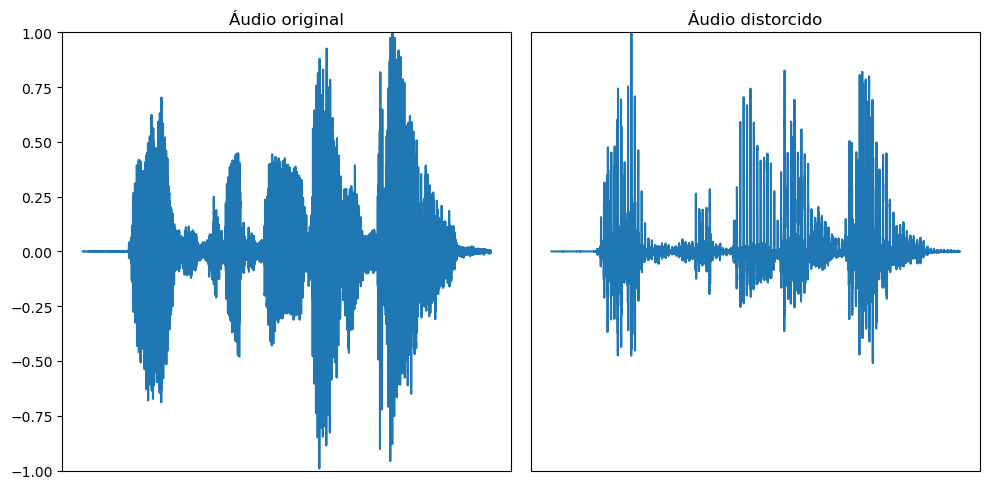

In [28]:
## visualização

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(audio_exemplo)
axes[0].set_title("Áudio original")
axes[0].set_xticks([])
axes[0].set_ylim(-1, 1)

axes[1].plot(exemplo_distorcido)
axes[1].set_title("Áudio distorcido")
axes[1].set_xticks([])
axes[1].set_ylim(-1, 1)
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

<h2><u>Parte 3.</u> Apresentando o dataset</h2>

In [68]:
## todo: definir dataset / normalizar

<h2><u>Parte 4.</u> Convertendo áudio em espectrograma</h2>

In [65]:
def audio2Spectrogram(audio):
    ''' 
    Função para converter áudio em espectrograma
    Input: áudio para ser convertido
    '''
    
    spectrogram = librosa.stft(audio)
    spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))
    
    return spectrogram_db

def mostrarEspectrograma(espectrograma, descricao):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(espectrograma, y_axis='hz', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(descricao)
    plt.tight_layout()
    plt.show()

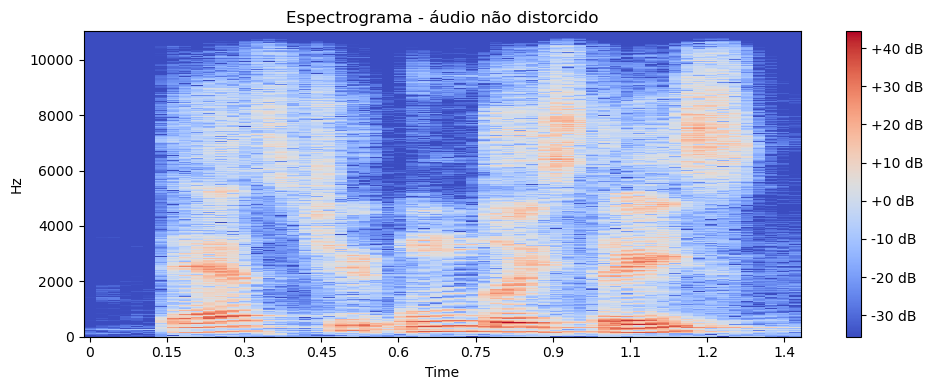

In [66]:
exemplo_espectrograma = audio2Spectrogram(audio_exemplo)
mostrarEspectrograma(exemplo_espectrograma, "Espectrograma - áudio não distorcido")

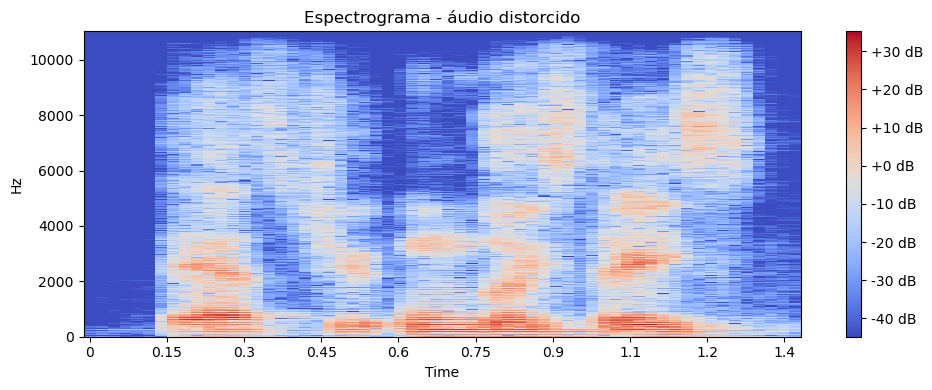

In [67]:
exemplo_espectrograma_dist = audio2Spectrogram(exemplo_distorcido)
mostrarEspectrograma(exemplo_espectrograma_dist, "Espectrograma - áudio distorcido")

<h2><u>Parte 5.</u> Pré-processamento</h2>
<p>Vamos dividir em duas partes:
    <br><b>1) Supressão de ruído</b> - vamos usar um Denoising Autoencoder (DAE)
    <br><b>2) Data Augmentation</b> - ampliar o dataset, aplicaremos as seguintes variações:
    <br> - <u>Time shift</u> (np.roll)
    <br> - <u>Mudar velocidade</u> (librosa.effects.time_stretch)
    <br> - <u>Mudar o tom</u> (librosa.effects.pitch_shift)
</p>

<h2><u>IDEIA:</u> Reconhecimento de voz recorrente</h2>
<p>Ao alimentar a GAN com um áudio, teremos um áudio de saída. Não temos como saber
se esse áudio está nítido ou compreensível, para isso, vamos passar o áudio de
saída em um STT (speech to text). Caso o STT tenha dificuldade de identificar o que
o áudio esteja falando (por exemplo, se o STT identificar que o áudio diz "Olá mundo"
com 15% de certeza), vamos gerar outro áudio com a GAN. Faremos isso até que
o STT tenha uma certeza maior ou igual a <b>N</b> que ele disse algo.<br>
<u><b>OBS:</b></u> Não será necessário comparar o que o STT entendeu com o que realmente
foi dito, pense no seguinte exemplo: Se temos uma GAN para gerar fotos de animais e
passamos alguma foto gerada pela mesma em uma IA para identificar animais e ela nos
diz que algum animal foi identificado com uma certeza de 90%. Não faz diferença se ela
identificou um cachorro ou um gato, o importante é que ela conseguiu identificar
algo com uma precisão alta, portanto temos uma saída "convincente".</p>

<img src="https://i.imgur.com/wZgyfkW.png" align="center">